[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/33_retrieval_probabillity_and_latency.ipynb)

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import numpy as np

In [2]:
def base_activation(pres_times, moments):
    base_act = np.zeros(len(moments))
    for idx in range(len(moments)):
        past_pres_times = pres_times[pres_times<moments[idx]]
        base_act[idx] = \
            np.sum(1/np.sqrt(moments[idx] - past_pres_times))
    non_zero_activations = np.not_equal(base_act, 0)
    base_act[non_zero_activations] = \
        np.log(base_act[np.not_equal(base_act, 0)])
    
    return base_act

In [3]:
pres_times = np.linspace(0, 5000, 5)/1000
moments = np.arange(10000)/1000
base_act = base_activation(pres_times, moments)

## Activation, probability of retrieval, and latency of retrieval

Now that we have a formal model of activation with its two components, namely:

- base activation that encodes the effects of prior use on memory, and
- spreading activation that encodes contextual effects

we can turn to how we can predict human performance based on activation.

These two components of activation have roles similar to the model $\mathcal{M}$ and the variable assignment $g$ parameters of the interpretation function $[\![\cdot]\!]^{\mathcal{M},g}$ in formal semantics:

- the model $\mathcal{M}$ is parallel to base activation, as it encodes more permanent, context-invariant information
- the variable assignment $g$ is parallel to spreading activation, as it encodes contextually-sensitive information of a more transient nature

Recall that the two behavioral measures we are trying to predict are:

- the probability of selecting a particular response, specifically of retrieving a chunk from memory
- the latency of selecting a response, specifically the time taken by the retrieval process

The relevant equations are provided below.

**Probability of retrieval equation**: $P_{i} = \frac{1}{1 + e^{-\frac{A_{i} - \tau}{s}}}$, where:

- $s$ is the noise parameter and is typically set to about $0.4$
- $\tau$ is the retrieval threshold, i.e., the activation at which we have a chance-level ($0.5$) retrieval probability
    - When $A_{i} = \tau$, we have: $P_{i} = \frac{1}{1 + e^{-\frac{\tau - \tau}{s}}} = \frac{1}{1 + e^{0}} = \frac{1}{2}$

**Latency of retrieval equation**: $T_{i} = F e^{-fA_{i}}$, where:

- $F$ is the latency factor (basically, an intercept on log time scale)
- $f$ is the latency exponent (a slope on log time scale)
    - on log time scale, we have: $\log T_{i} = \log(F e^{-fA_{i}}) = \log F - f A_{i}$

In addition to the activation $A_{i}$ of chunk $i$, these equations have a few parameters

- the threshold parameter $\tau$ in the probability of retrieval equation and the latency factor $F$ in the latency equation vary from model to model, but there is a general relationship between them
    - $F \approx 0.35 e^{\tau}$, i.e., the retrieval latency at threshold is approximately $0.35$ s / $350$ ms
    - when $A_{i} = \tau$, we have: $T_{i} = F e^{-A_{i}} = F e^{-\tau} \approx 0.35 e^{\tau} e^{-\tau} = 0.35$

To understand the two equations above a bit better, recall our discussion of base activation, and the important remark that:

- activation $A_{i}$ is really the log of the need-odds of a particular chunk $i$
- that is, $A_{i}$ is the logit (log odds) transformation of the need-probability of chunk $i$
- the need-probability of chunk $i$ is just the probability that chunk $i$ is the one needed to satisfy the current memory retrieval request
- talking about need-probability is interchangeable with talking about need-odds or activation, which is just need-logits

Here's how we can compute need-odds and activation (need-logits) if we are given the need-probability $p_i$ of chunk $i$.
- Given the need-probability $p_{i}$ for chunk $i$, we have:
   - need-odds $o_{i} = \frac{p_{i}}{1-p_{i}}$
   - need-logits / activation $A_{i} = \log o_{i} = \log \frac{p_{i}}{1-p_{i}}$

Here's how we can compute need odds and need probability if we are given the activation $A_i$ (i.e., the need logits $A_i$) for chunk $i$:

- Given the activation / need-logits $A_{i}$ for chunk $i$, we have:
   - need-odds $o_{i} = e^{A_{i}}$
   - need-probability $p_{i} = \frac{o_{i}}{1 + o_{i}} = \frac{e^{A_{i}}}{1 + e^{A_{i}}}$
       - equivalently, $p_{i} = \frac{1}{1 + \frac{1}{o_{i}}} = \frac{1}{1 + \frac{1}{e^{A_{i}}}} = \frac{1}{1 + e^{-A_{i}}}$

The very last equation above, which takes us from activation (need logits) to need probability is exactly the equation we used to obtain probability of retrieval above.

- the only difference is that we add two more parameters:
    - the threshold $\tau$
    - the noise $s$
- these parameters enable us to make the model more realistic / flexible so that we can fit different kinds of data well

Thus, the probability of retrieval equation immediately follows from the fact that we take activation to encode the log odds (logit) transformation of need-probability.

The latency of retrieval equation is equally intuitive.

- ignoring the parameters $F$ and $f$, i.e., setting them to $1$ (incidentally, this is the common default value for $f$), we have that:
    - $T_{i} = e^{-A_{i}} = \frac{1}{e^{A_{i}}} = \frac{1}{o_{i}}$ (if we set $F = f = 1$)

- that is, the retrieval latency for chunk $i$ is inversely proportional to the need-odds of $i$:
    - the higher the need-odds for chunk $i$, the less time it will take to retrieve it
    - the lower the need-odds for chunk $i$, the more time it will take to retrieve it
    
- the need-odds for a chunk $i$ are high if:
    - the chunk has been used a lot and/or recently (this comes from base activation)
    - the chunk is highly relevant given the current cognitive context (this comes from spreading activation)
    
- so it makes sense that such a chunk would be easy / fast to retrieve: it was retrieved a lot and/or recently and it is strongly associated with what the cognitive process is current attending to

Finally, modeling retrieval times/latencies as inversely proportional to need-odds makes mathematical sense:

- while probabilities take values in the interval $[0,1]$, odds take values in the interval $[0, \infty)$, i.e., in the set of positive real numbers (and $0$)
- this is the same interval in which reaction times/latencies also take values

Let's now work through an example. 

- we will plot the probability and latency of retrieval for the same hypothetical case as before - the one involving the ```carLexeme``` chunk
- we assume the activation of the ```carLexeme``` chunk is just its base-level activation
- we set the parameters as follows:
    - noise $s = 0.4$
    - threshold $\tau = 0.3$
    - latency factor $F = 0.47$
    - latency exponent $f = 1$

- according to the $\tau$-$F$ relationship equation, $F \approx 0.35 e^{0.3} \approx 0.35 \times 1.35 \approx 0.47$ s, which is what we set our $F$ value to
    
- of course, we pulled the values for these parameters out of thin air for this particular example
- in general, we want to use statistical inference (e.g., Bayesian methods with ```pymc3```) to estimate these parameters from the data

- we use the previously computed vector ```base_act``` of base activations to compute the probabilities of retrieval and the latencies of retrieval for the $10$ s we are interested in
- we then plot these three curves (activation, retrieval probability, retrieval latency)

In [4]:
s = 0.4
tau = 0.3
F = 0.47
f = 1
prob_retrieval = 1 / (1 + np.exp(-(base_act - tau)/s))
prob_retrieval
latency_retrieval = F * np.exp(-f*base_act)
# latency of retrieval in ms
(latency_retrieval * 1000).astype("int")
threshold_prob_scale = 1 / (1 + np.exp(-(tau-tau)/s)) # =1/(1+1)
# it's 1/2, i.e., 50% probability when activation is at threshold
threshold_prob_scale
threshold_latency_scale = F * np.exp(-tau)
# time to retrieve in ms when activation is at threshold
(threshold_latency_scale * 1000).astype("int")

348

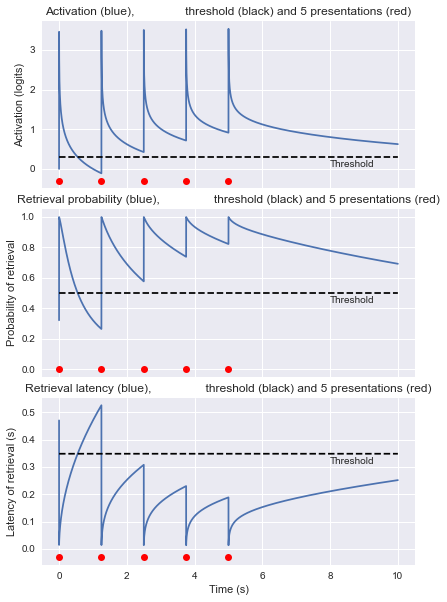

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharex=True)
fig.set_size_inches(5.8, 8.3)

# plot 1
ax1.plot(moments, base_act, linestyle='-')
ax1.plot(pres_times, np.ones(5) * -0.3, 'ro')
ax1.plot(moments, np.ones(len(moments)) * tau,\
         linestyle='--', color='black')
ax1.annotate('Threshold', xy=(8, tau - 0.26), size=10)
ax1.set_title('Activation (blue),\
               threshold (black) and 5 presentations (red)')
ax1.set_ylabel('Activation (logits)')

# plot 2
ax2.plot(moments, prob_retrieval, linestyle='-')
ax2.plot(pres_times, np.zeros(5), 'ro')
ax2.plot(moments, np.ones(len(moments)) * threshold_prob_scale,\
        linestyle='--', color='black')
ax2.annotate('Threshold', xy=(8, threshold_prob_scale - 0.067),\
             size=10)
ax2.set_title('Retrieval probability (blue), \
               threshold (black) and 5 presentations (red)')
ax2.set_ylabel('Probability of retrieval')

# plot 3
ax3.plot(moments, latency_retrieval, linestyle='-')
ax3.plot(pres_times, np.ones(5) * -0.03, 'ro')
ax3.plot(moments, np.ones(len(moments)) * threshold_latency_scale,\
        linestyle='--', color='black')
ax3.annotate('Threshold', xy=(8, threshold_latency_scale - 0.037),\
             size=10)
ax3.set_title('Retrieval latency (blue), \
               threshold (black) and 5 presentations (red)')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Latency of retrieval (s)')

# clean up
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

We plot the threshold $\tau$ as a dashed black line in every plot:

- in the top panel, we plot its raw value ($0.3$) on the activation (logit) scale
- in the middle panel, the threshold is at $50\%$ probability, as intended given that activation at threshold level should yield even odds of retrieval ($1/1$; chance level)
- in the bottom panel, the threshold is at about $350$ ms, which is the time of retrieval when activation is at threshold level; this is actually determined by the constant $0.35$ ($350$ ms) we used in the $\tau-F$ relationship equation

We see that, as activation increases above threshold after the fourth and fifth presentation / rehearsal of the ```carLexeme``` chunk (see the top panel in the figure), retrieval accuracy increases above chance (see the plot in the middle panel) and the retrieval becomes faster and faster (retrieval time decreases below $340$ ms; see plot in bottom panel).

Remarkably, the ACT-R account of declarative memory unifies two separate measures (retrieval accuracy and retrieval latency) under one quantity: activation.

Furthermore, activation can be independently derived if we know, or can reasonable conjecture:

- the pattern of previous use for a chunk -- this will give us the base activation component;
- the cognitive context -- this will give us the spreading activation component.